In [7]:
%matplotlib inline
import torch 
import matplotlib.pyplot as plt
from fmfts.experiments.ns2d.training_parameters import params
import copy
from fmfts.experiments.ns2d.models import VelocityModelNS2D, FlowModelNS2D, SingleStepModelNS2D
from fmfts.dataloader.ns2d import DatasetNS2D

torch.set_grad_enabled(False)
torch.set_default_device("cuda")

velocity = VelocityModelNS2D(**params["velocity"]["model_kwargs"])
#velocity.load_state_dict(torch.load("trained_models/state_velocity_pd.pt", weights_only=True)["model"])
state = torch.load("trained_models/state_velocity_pd.pt", weights_only=True)
velocity.load_state_dict(state["model"], strict=False)

flow = FlowModelNS2D(velocity_model = copy.deepcopy(velocity), **params["flow"]["model_kwargs"])
#flow.load_state_dict(torch.load("trained_models/state_flow.pt", weights_only=True, strict= False)["model"])
state = torch.load("trained_models/state_flow.pt", weights_only=True)
flow.load_state_dict(state["model"], strict=False)

# single_step = SingleStepModelNS2D(velocity_model = copy.deepcopy(velocity), **params["single_step"]["model_kwargs"])
# single_step.load_state_dict(torch.load("trained_models/state_single_step.pt", weights_only=True)["model"])
dataset_test = DatasetNS2D(mode = "test")

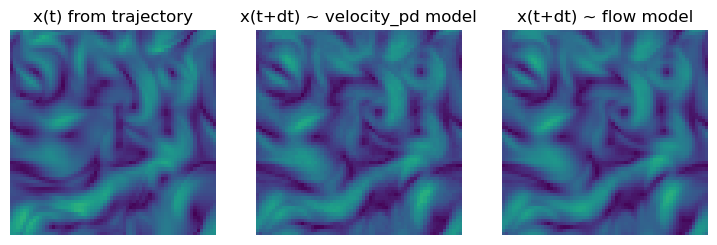

In [8]:
# demonstrates how one can predict a single sample
y = dataset_test.get(3, 0, sequence_len=1)
x = dataset_test.get(3, 1, sequence_len=1)
x0 = velocity.p0.sample(y.shape).to(y.device)
x_pred_v = velocity.sample(y, x0=x0, steps=50, method="midpoint")
x_pred_f = flow.sample(y, x0=x0, steps=1)

# plotting
fig, ax = plt.subplots(1, 3, figsize=(3*3, 3))
dataset_test.plot(y, ax[0])
dataset_test.plot(x_pred_v, ax[1])
dataset_test.plot(x_pred_f, ax[2])
for i in range(3): ax[i].axis("off")
ax[0].set_title("x(t) from trajectory")
ax[1].set_title("x(t+dt) ~ velocity_pd model")
ax[2].set_title("x(t+dt) ~ flow model")
plt.show()

In [9]:
# def plot_spectrum(x, ax, label=""):
#     x_hat = torch.fft.fft2(x)
#     magnitude_spectrum = x_hat.abs().pow(2).mean(dim=0)
#     magnitude_spectrum_shifted = torch.fft.fftshift(magnitude_spectrum, dim=(-2,-1))
# 
#     radius = lambda x, y: (x**2 + y**2)**0.5
#     x_ = torch.arange(x.shape[-2]) - x.shape[-2]//2
#     y_ = torch.arange(x.shape[-1]) - x.shape[-1]//2
#     X, Y = torch.meshgrid(x_, y_, indexing='ij')
#     r = radius(X, Y)
# 
#     r_int = r.to(torch.int)
#     energy_spectrum = torch.tensor([torch.sum(magnitude_spectrum_shifted[r_int == i]**2) for i in range(32)])
#     ax.plot(energy_spectrum.cpu().numpy(), label=label)
# 
# fig, ax = plt.subplots(1, 1, figsize=(3,3))
# plot_spectrum(x_pred_f[0], ax, label="flow")
# plot_spectrum(x_pred_v[0], ax, label="velocity")
# plot_spectrum(y[0], ax, label="true")
# ax.set_yscale("log")
# ax.legend()
# plt.show()
# 
# energy_flow = dataset_test.compute_energy(x_pred_f)
# energy_v = dataset_test.compute_energy(x_pred_v)
# energy_true = dataset_test.compute_energy(y)
# plt.hist(energy_v.flatten().cpu().numpy(), histtype="step", bins=50, density=True)
# plt.hist(energy_true.flatten().cpu().numpy(), histtype="step", bins=50, density=True)
# plt.yscale("log")
# plt.show()

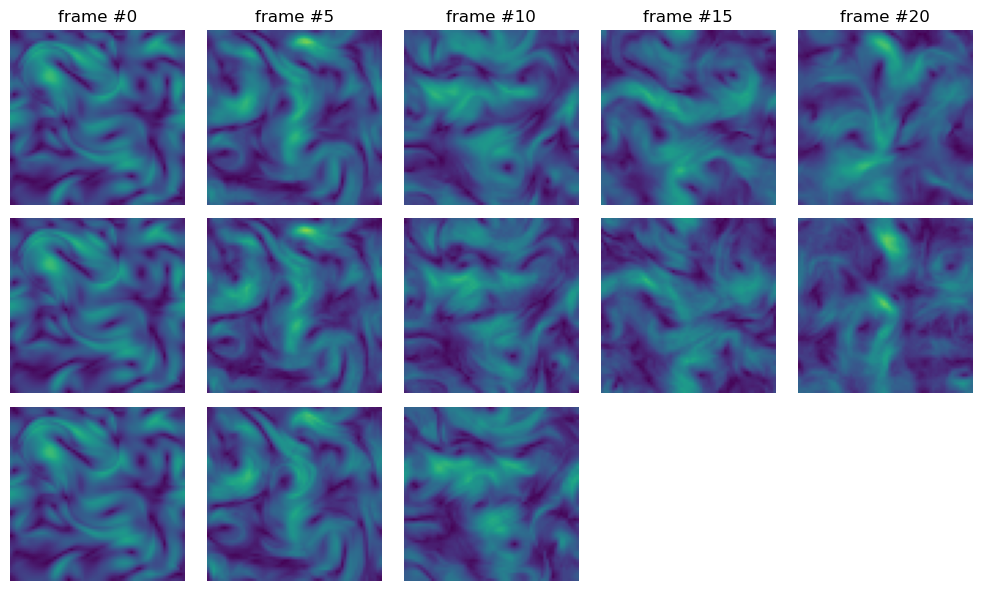

In [9]:
n_predictions = 25
y = dataset_test.get(10, 0, sequence_len=15)

xs = torch.empty(n_predictions, 2, *y.shape[1:])
xs[0,:] = y[0].clone()
for k in range(n_predictions-1):
    x0 = flow.p0.sample(xs[k,0,None].shape).to(y.device)
    xs[k+1,0,None] = flow.sample(xs[k,0,None], x0=x0, steps=1)
    xs[k+1,1,None] = velocity.sample(xs[k,1,None], x0=x0, steps=5, method="midpoint")

n_plots   = 5
fig, ax = plt.subplots(3, n_plots, figsize=(n_plots*2, 3*2))
for k in range(2):
    for i in range(n_plots):
        l = i * n_predictions // n_plots
        dataset_test.plot(xs[l, k], ax[k, i])
        ax[k,i].axis("off")
    ax[k,0].set_ylabel(f"sampled trajectory #{k+1}")

for i in range(n_plots):
    l = i * n_predictions // n_plots
    if l < len(y): 
        dataset_test.plot(y[l], ax[-1, i])
        ax[-1, i].axis("off")
    else:                          
        ax[-1, i].remove()

    ax[0, i].set_title(f"frame #{l}")
ax[-1, 0].set_ylabel("true trajectory")

plt.tight_layout()
plt.show()

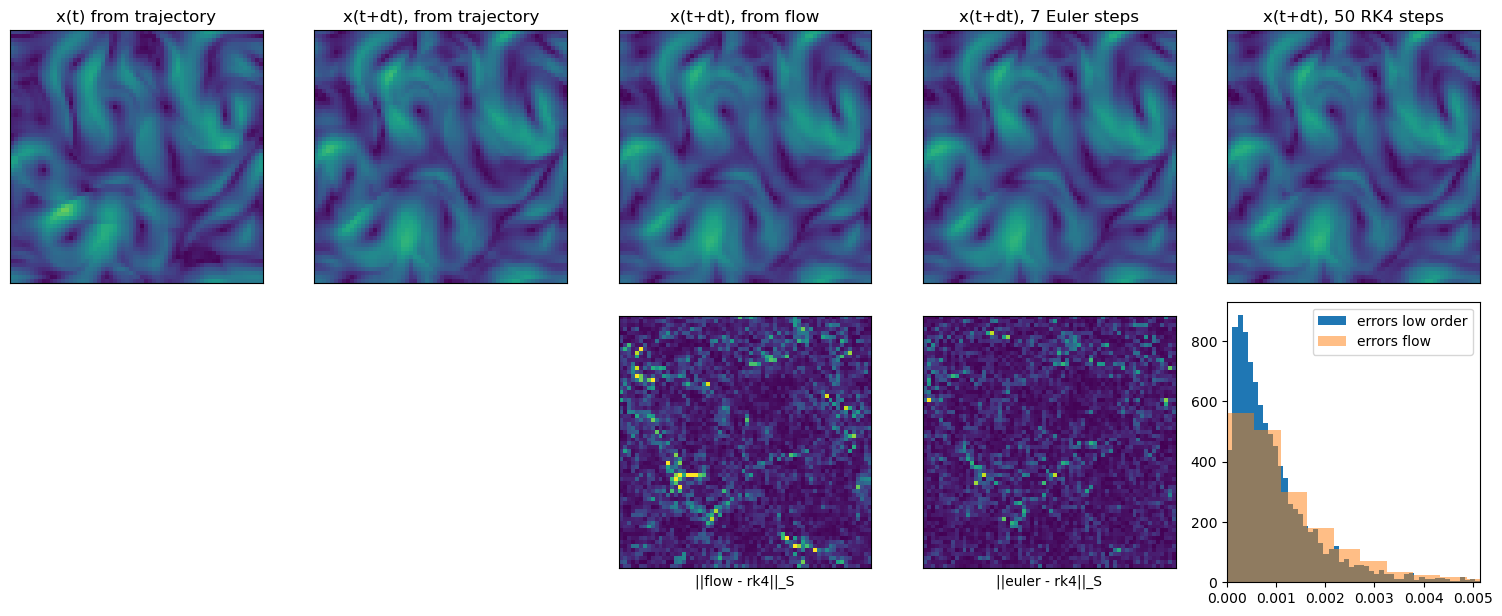

In [10]:
from fmfts.utils.loss_fn import sobolev

n_steps_lo = 7

# demonstrates how one can predict a single sample
y, x = dataset_test.get(1, 0, sequence_len=2)
y, x = y.unsqueeze(0), x.unsqueeze(0)
x0 = flow.p0.sample(y.shape).to("cuda")
x_pred_f = flow.sample(y, steps=1, x0=x0)
x_pred_v_lo = flow.v.sample(y, steps= n_steps_lo, x0=x0, method="euler")
x_pred_v_ho = flow.v.sample(y, steps=         50, x0=x0, method="rk4")

fig, ax = plt.subplots(2, 5, figsize=(3*5, 3*2.1))
dataset_test.plot(y, ax[0,0])
dataset_test.plot(x, ax[0,1])
dataset_test.plot(x_pred_f, ax[0,2])
dataset_test.plot(x_pred_v_lo, ax[0,3])
dataset_test.plot(x_pred_v_ho, ax[0,4])

error_flow  = sobolev(x_pred_f - x_pred_v_ho,    alpha=1.0, beta=0.0, t=torch.ones(1), pointwise=True)
error_lo    = sobolev(x_pred_v_lo - x_pred_v_ho, alpha=1.0, beta=0.0, t=torch.ones(1), pointwise=True)
error_flow = error_flow.mean(dim=1)
error_lo   = error_lo.mean(dim=1)

ax[1,2].imshow( error_flow[0].cpu().numpy(), vmin=0, vmax=0.01 )
ax[1,3].imshow( error_lo[0].cpu().numpy(), vmin=0, vmax=0.01)
ax[1,4].hist( error_lo.flatten().cpu().numpy(),   bins=100, alpha=1.0, label="errors low order", density=True )
ax[1,4].hist( error_flow.flatten().cpu().numpy(), bins=100, alpha=0.5, label="errors flow",      density=True )
ax[1,4].legend()
ax[1,4].set_xlim([0, error_lo.max().cpu().numpy()*0.5])

ax[1,0].remove()
ax[1,1].remove()
ax[0,0].set_title("x(t) from trajectory")
ax[0,1].set_title("x(t+dt), from trajectory")
ax[0,2].set_title("x(t+dt), from flow")
ax[0,3].set_title(f"x(t+dt), {n_steps_lo} Euler steps")
ax[0,4].set_title("x(t+dt), 50 RK4 steps")
for i in range(4): 
    for j in range(2):
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([])
ax[0,4].set_xticks([])
ax[0,4].set_yticks([])

ax[1,2].set_xlabel("||flow - rk4||_S")
ax[1,3].set_xlabel("||euler - rk4||_S")

plt.tight_layout()
plt.show()
